<a href="https://colab.research.google.com/github/rajy4683/EVAP2/blob/master/ENDS7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0 TorchText

## Dataset Preview

Your first step to deep learning in NLP. We will be mostly using PyTorch. Just like torchvision, PyTorch provides an official library, torchtext, for handling text-processing pipelines. 

We will be using previous session tweet dataset. Let's just preview the dataset.

In [ ]:
import pandas as pd
df = pd.read_csv('./tweets.csv')
df.head()

,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1


In [ ]:
df.shape

(1364, 2)

In [ ]:
df.labels.value_counts()

0    931
1    352
2     81
Name: labels, dtype: int64

## Defining Fields

Now we shall be defining LABEL as a LabelField, which is a subclass of Field that sets sequen tial to False (as it’s our numerical category class). TWEET is a standard Field object, where we have decided to use the spaCy tokenizer and convert all the text to lower‐ case.

In [1]:
# Import Library
import random
import torch, torchtext
from torchtext import data 
import pandas as pd
import numpy as np
import os, pickle

# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [ ]:
Tweet = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:

In [ ]:
fields = [('tweets', Tweet),('labels',Label)]

In [ ]:
df.tweets

0       Obama has called the GOP budget social Darwini...
1       In his teen years, Obama has been known to use...
2       IPA Congratulates President Barack Obama for L...
3       RT @Professor_Why: #WhatsRomneyHiding - his co...
4       RT @wardollarshome: Obama has approved more ta...
                              ...                        
1359    @liberalminds Its trending idiot.. Did you loo...
1360    RT @AstoldByBass: #KimKardashiansNextBoyfriend...
1361    RT @GatorNation41: gas was $1.92 when Obama to...
1362    @xShwag haha i know im just so smart, i mean y...
1363    #OBAMA:  DICTATOR IN TRAINING.  If he passes t...
Name: tweets, Length: 1364, dtype: object

Armed with our declared fields, lets convert from pandas to list to torchtext. We could also use TabularDataset to apply that definition to the CSV directly but showing an alternative approach too.

In [ ]:
example = [data.Example.fromlist([df.tweets[i],df.labels[i]], fields) for i in range(df.shape[0])] 

In [ ]:
myexample = example[0]

In [ ]:
myexample.tweets

['Obama',
 'has',
 'called',
 'the',
 'GOP',
 'budget',
 'social',
 'Darwinism',
 '.',
 'Nice',
 'try',
 ',',
 'but',
 'they',
 'believe',
 'in',
 'social',
 'creationism',
 '.']

In [ ]:
# Creating dataset
#twitterDataset = data.TabularDataset(path="tweets.csv", format="CSV", fields=fields, skip_header=True)

twitterDataset = data.Dataset(example, fields)

In [ ]:
twitterDataset.fields

{'labels': <torchtext.data.field.LabelField at 0x7fe776fc30b8>,
 'tweets': <torchtext.data.field.Field at 0x7fe776fb0978>}

Finally, we can split into training, testing, and validation sets by using the split() method:

In [ ]:
(train, valid) = twitterDataset.split(split_ratio=[0.85, 0.15], random_state=random.seed(SEED))

In [ ]:
(len(train), len(valid))

(1159, 205)

An example from the dataset:

In [ ]:
vars(train.examples[10])

{'labels': 0,
 'tweets': ['Obama',
  ',',
  'Romney',
  'agree',
  ':',
  'Admit',
  'women',
  'to',
  'Augusta',
  'golf',
  'club',
  ':',
  'US',
  'President',
  'Barack',
  'Obama',
  'believes',
  'women',
  'should',
  'be',
  'allowe',
  '...',
  'http://t.co/PVKrepqI']}

## Building Vocabulary

At this point we would have built a one-hot encoding of each word that is present in the dataset—a rather tedious process. Thankfully, torchtext will do this for us, and will also allow a max_size parameter to be passed in to limit the vocabu‐ lary to the most common words. This is normally done to prevent the construction of a huge, memory-hungry model. We don’t want our GPUs too overwhelmed, after all. 

Let’s limit the vocabulary to a maximum of 5000 words in our training set:


In [ ]:
Tweet.build_vocab(train)
Label.build_vocab(train)

By default, torchtext will add two more special tokens, <unk> for unknown words and <pad>, a padding token that will be used to pad all our text to roughly the same size to help with efficient batching on the GPU.

In [ ]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  4651
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 1069), (':', 783), ('#', 780), ('.', 761), (',', 598), ('"', 550), ('the', 542), ('RT', 516), ('?', 419), ('to', 400)]
Labels :  defaultdict(<function _default_unk_index at 0x7fe776fd97b8>, {0: 0, 1: 1, 2: 2})


**Lots of stopwords!!**

Now we need to create a data loader to feed into our training loop. Torchtext provides the BucketIterator method that will produce what it calls a Batch, which is almost, but not quite, like the data loader we used on images.

But at first declare the device we are using.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.tweets),
                                                            sort_within_batch=True, device = device)

Save the vocabulary for later use

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

## Defining Our Model

We use the Embedding and LSTM modules in PyTorch to build a simple model for classifying tweets.

In this model we create three layers. 
1. First, the words in our tweets are pushed into an Embedding layer, which we have established as a 300-dimensional vector embedding. 
2. That’s then fed into a 2 stacked-LSTMs with 100 hidden features (again, we’re compressing down from the 300-dimensional input like we did with images). We are using 2 LSTMs for using the dropout.
3. Finally, the output of the LSTM (the final hidden state after processing the incoming tweet) is pushed through a standard fully connected layer with three outputs to correspond to our three possible classes (negative, positive, or neutral).

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [9]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 3
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

NameError: ignored

In [ ]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(4651, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)
The model has 1,637,203 trainable parameters


## Model Training and Evaluation

First define the optimizer and loss functions

In [8]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

NameError: ignored

The main thing to be aware of in this new training loop is that we have to reference `batch.tweets` and `batch.labels` to get the particular fields we’re interested in; they don’t fall out quite as nicely from the enumerator as they do in torchvision.

**Training Loop**

In [3]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweets   
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Evaluation Loop**

In [ ]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweets
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Let's Train and Evaluate**

In [ ]:
N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 1.065 | Train Acc: 49.98%
	 Val. Loss: 1.014 |  Val. Acc: 58.48% 

	Train Loss: 0.993 | Train Acc: 64.06%
	 Val. Loss: 0.949 |  Val. Acc: 64.73% 

	Train Loss: 0.927 | Train Acc: 69.12%
	 Val. Loss: 0.901 |  Val. Acc: 67.86% 

	Train Loss: 0.869 | Train Acc: 69.88%
	 Val. Loss: 0.857 |  Val. Acc: 73.21% 

	Train Loss: 0.824 | Train Acc: 74.87%
	 Val. Loss: 0.833 |  Val. Acc: 74.55% 

	Train Loss: 0.796 | Train Acc: 77.74%
	 Val. Loss: 0.820 |  Val. Acc: 75.89% 

	Train Loss: 0.776 | Train Acc: 78.67%
	 Val. Loss: 0.807 |  Val. Acc: 75.89% 

	Train Loss: 0.760 | Train Acc: 80.24%
	 Val. Loss: 0.802 |  Val. Acc: 76.79% 

	Train Loss: 0.746 | Train Acc: 81.67%
	 Val. Loss: 0.797 |  Val. Acc: 77.23% 

	Train Loss: 0.731 | Train Acc: 83.28%
	 Val. Loss: 0.791 |  Val. Acc: 77.68% 



## Model Testing

In [ ]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]

In [ ]:
classify_tweet("A valid explanation for why Trump won't let women on the golf course.")

'Negative'

## Discussion on Data Augmentation Techniques 

You might wonder exactly how you can augment text data. After all, you can’t really flip it horizontally as you can an image! :D 

In contrast to data augmentation in images, augmentation techniques on data is very specific to final product you are building. As its general usage on any type of textual data doesn't provides a significant performance boost, that's why unlike torchvision, torchtext doesn’t offer a augmentation pipeline. Due to powerful models as transformers, augmentation tecnhiques are not so preferred now-a-days. But its better to know about some techniques with text that will provide your model with a little more information for training. 

### Synonym Replacement

First, you could replace words in the sentence with synonyms, like so:

    The dog slept on the mat

could become

    The dog slept on the rug

Aside from the dog's insistence that a rug is much softer than a mat, the meaning of the sentence hasn’t changed. But mat and rug will be mapped to different indices in the vocabulary, so the model will learn that the two sentences map to the same label, and hopefully that there’s a connection between those two words, as everything else in the sentences is the same.

### Random Insertion
A random insertion technique looks at a sentence and then randomly inserts synonyms of existing non-stopwords into the sentence n times. Assuming you have a way of getting a synonym of a word and a way of eliminating stopwords (common words such as and, it, the, etc.), shown, but not implemented, in this function via get_synonyms() and get_stopwords(), an implementation of this would be as follows:


In [ ]:
def random_insertion(sentence, n): 
    words = remove_stopwords(sentence) 
    for _ in range(n):
        new_synonym = get_synonyms(random.choice(words))
        sentence.insert(randrange(len(sentence)+1), new_synonym) 
    return sentence

## Random Deletion
As the name suggests, random deletion deletes words from a sentence. Given a probability parameter p, it will go through the sentence and decide whether to delete a word or not based on that random probability. Consider of it as pixel dropouts while treating images.

In [ ]:
def random_deletion(words, p=0.5): 
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return remaining

### Random Swap
The random swap augmentation takes a sentence and then swaps words within it n times, with each iteration working on the previously swapped sentence. Here we sample two random numbers based on the length of the sentence, and then just keep swapping until we hit n.

In [ ]:
def random_swap(sentence, n=5): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

For more on this please go through this [paper](https://arxiv.org/pdf/1901.11196.pdf).

### Back Translation

Another popular approach for augmenting text datasets is back translation. This involves translating a sentence from our target language into one or more other languages and then translating all of them back to the original language. We can use the Python library googletrans for this purpose. 

In [2]:
#!pip install googletrans==4.0.0-rc1
!pip install googletrans==3.1.0a0

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 983kB 6.9MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 102kB 7.3MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-cp36-none-any.whl size=16369 sha256=bac2c4e99d9b4a34af3ffc12c90f7431e9e1831682fc3a56876c8eb7440a6a85
  Stored in directory: /root/.cache/pip/wheels/27/7a/a0/aff3babbb775549ce6813cb8fa7ff3c0848c4dc62c20f8fdac
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=8af25f2d88da725d254f117f253771b806e33808e1ecdd342e0a67c08d271f20
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [12]:
import random
import googletrans
#import googletrans.Translator as Translator

translator = googletrans.Translator()
sentence = ['The dog slept on the rug', 'ran lazily']

available_langs = list(googletrans.LANGUAGES.keys()) 
trans_lang = random.choice(available_langs) 
print(f"Translating to {googletrans.LANGUAGES[trans_lang]}")

trans_lang

Translating to armenian


'hy'

In [13]:
sentence = ['The dog slept on the rug']
available_langs = list(googletrans.LANGUAGES.keys()) 
trans_lang = random.choice(available_langs) 
print(f"Translating to {googletrans.LANGUAGES[trans_lang]}")

Translating to kurdish (kurmanji)


In [15]:
translations = translator.translate(sentence, dest=trans_lang) 
t_text = [t.text for t in translations]
print(t_text)

['Kûçik li ser xalîçeyê razaye']


In [16]:
translations_en_random = translator.translate(t_text, src=trans_lang, dest='en') 
en_text = [t.text for t in translations_en_random]
print(en_text)

['The dog is lying on the carpet']


In [ ]:
#!pip install google_trans_new


In [ ]:
len(available_langs)

107

### Stanford Sentiment Analysis TreeBank

In [3]:
import pandas as pd
import numpy as np

In [ ]:
datasetSentences_df = pd.read_csv("/content/datasetSentences.txt", sep="\t")
dictionary_df = pd.read_csv("/content/dictionary.txt", sep="|", names=["Phrase", "Phrase_Id"])
sentiment_labels_df =  pd.read_csv("/content/sentiment_labels.txt", sep="|")

In [ ]:
datasetSentences_df["Phrase_Id"] = 0
datasetSentences_df["Sentiment_Score"] = 0

In [ ]:
common_sentences = datasetSentences_df[datasetSentences_df["sentence"].isin(dictionary_df["Phrase"])]
common_sentences

,sentence_index,sentence,Phrase_Id
0,1,The Rock is destined to be the 21st Century 's...,224044
1,2,The gorgeously elaborate continuation of `` Th...,224044
2,3,Effective but too-tepid biopic,224044
3,4,If you sometimes like to go to the movies to h...,224044
4,5,"Emerges as something rare , an issue movie tha...",224044
...,...,...,...
11850,11851,A real snooze .,224044
11851,11852,No surprises .,224044
11852,11853,We 've seen the hippie-turned-yuppie plot befo...,224044
11853,11854,Her fans walked out muttering words like `` ho...,224044


### Create Dataframe to have sentiment scores and Full sentences together.

In [ ]:
def sentence_exists(input_sentence):
    #print(input_sentence)
    matching_phrase = dictionary_df[dictionary_df["Phrase"] == input_sentence]["Phrase_Id"].values
    default_series = pd.Series({"Phrase_Id":-1000, "Sentiment_Score": -1000}) ## For cases where we dont find a full sentence match
    if(len(matching_phrase)) > 0:
        phrase_id = np.int(matching_phrase[0])
        sentiment_value = sentiment_labels_df[sentiment_labels_df["phrase ids"] == matching_phrase[0]]["sentiment values"].values[0]
        default_series = pd.Series({"Phrase_Id":phrase_id, "Sentiment_Score": sentiment_value})

    return default_series


datasetSentences_df.loc[:, ["Phrase_Id", "Sentiment_Score"]] =  datasetSentences_df.loc[:,"sentence"].apply(sentence_exists)


In [ ]:
datasetSentences_df["Phrase_Id"] = datasetSentences_df["Phrase_Id"].astype('int')
datasetSentences_df = datasetSentences_df[datasetSentences_df["Phrase_Id"] > 0].iloc[:,:-1]
datasetSentences_df.to_csv("StanfordNLP.csv",index=False, sep="|")

In [ ]:
new_df = pd.read_csv("/content/StanfordNLP.csv",sep="|")

In [ ]:
new_df

,sentence_index,sentence,Phrase_Id,Sentiment_Score
0,1,The Rock is destined to be the 21st Century 's...,226166,0.69444
1,2,The gorgeously elaborate continuation of `` Th...,226300,0.83333
2,3,Effective but too-tepid biopic,13995,0.51389
3,4,If you sometimes like to go to the movies to h...,14123,0.73611
4,5,"Emerges as something rare , an issue movie tha...",13999,0.86111
...,...,...,...,...
11281,11851,A real snooze .,222071,0.11111
11282,11852,No surprises .,225165,0.22222
11283,11853,We 've seen the hippie-turned-yuppie plot befo...,226985,0.75000
11284,11854,Her fans walked out muttering words like `` ho...,223632,0.13889


In [ ]:
train_df = new_df.sample(frac = 0.8) 
test_df = new_df[~new_df.sentence_index.isin(train_df.sentence_index)]

In [ ]:
train_df.to_csv("StanTrain.csv",index=False, sep="|")
test_df.to_csv("StanTest.csv", index=False, sep="|")

In [ ]:
simpler_series_df = train_df.copy()

In [ ]:
empty_series = { col:[] for col in train_df.columns.values}

In [ ]:
from eda import *

In [ ]:
my_new_df = pd.DataFrame(data=empty_series)

In [ ]:
my_new_df.loc[len(my_new_df)] = [1 , "asdasd", 111, 0.9]

In [ ]:
my_new_df

,sentence_index,sentence,Phrase_Id,Sentiment_Score


In [ ]:
simpler_series_df

,sentence_index,sentence,Phrase_Id,Sentiment_Score
6867,7189,"` Lovely and Amazing , ' unhappily , is neithe...",151215,0.44444
10542,11074,"A bland , obnoxious 88-minute infomercial for ...",221946,0.23611
7219,7562,Tries to add some spice to its quirky sentimen...,150502,0.29167
2446,2547,Functions as both a revealing look at the coll...,65700,0.63889
9645,10116,It 's hard to quibble with a flick boasting th...,224187,0.66667
...,...,...,...,...
3919,4100,"Witty , contemplative , and sublimely beautiful .",71027,0.83333
6501,6802,Director Roger Michell does so many of the lit...,144877,0.41667
7141,7479,Made with no discernible craft and monstrously...,147300,0.22222
10484,11014,`` Not really as bad as you might think ! '',227547,0.54167


In [ ]:
simpler_series_df = train_df#simpler_series_df[:100]

In [ ]:
max_sentence_ids = simpler_series_df.sentence_index.max()
alpha_sr = 0.0
alpha_ri=0.0
alpha_rs=0.2
alpha_rd=0.2
num_aug=5

for idx in simpler_series_df.itertuples():
    #parts = line[:-1].split('\t')
    #label = parts[0]
    sentence = idx.sentence
    aug_sentences = eda(sentence, alpha_sr=alpha_sr, alpha_ri=alpha_ri, alpha_rs=alpha_rs, p_rd=alpha_rd, num_aug=num_aug)
    for aug_sentence in aug_sentences:
        max_sentence_ids += 1
        my_new_df.loc[len(my_new_df)] = [max_sentence_ids,aug_sentence, np.int(idx.Phrase_Id), idx.Sentiment_Score ]

In [ ]:
my_new_df

,sentence_index,sentence,Phrase_Id,Sentiment_Score
0,11855.0,and amazing is excessively strained contrived,151215.0,0.44444
1,11856.0,amazing and neither unhappily is lovely excess...,151215.0,0.44444
2,11857.0,neither and amazing contrived is lovely excess...,151215.0,0.44444
3,11858.0,lovely and unhappily is neither strained and c...,151215.0,0.44444
4,11859.0,lovely and amazing unhappily is neither excess...,151215.0,0.44444
...,...,...,...,...
45140,56995.0,not absolutely mention to refreshed,225210.0,0.80556
45141,56996.0,absolutely to mention not refreshed,225210.0,0.80556
45142,56997.0,not mention absolutely refreshed,225210.0,0.80556
45143,56998.0,not mention absolutely refreshed,225210.0,0.80556


In [ ]:
my_new_df = my_new_df.sample(frac = 1) 

In [ ]:
my_new_df.to_csv("StanAugmented.csv", index=False, sep="|")

In [ ]:
my_new_df.append(train_df,ignore_index=True)

,sentence_index,sentence,Phrase_Id,Sentiment_Score
0,34766.0,s performance confirms her once again,44733.0,0.88889
1,18024.0,what s the russian word for wow,227385.0,0.77778
2,23140.0,verve s stylishly directed with it,66669.0,0.75000
3,50084.0,without shakespeare s eloquent language the up...,111221.0,0.15278
4,28678.0,a de of cinema,103960.0,0.63889
...,...,...,...,...
54169,3075.0,This fascinating experiment plays as more of a...,70193.0,0.66667
54170,2645.0,Remove Spider-Man the movie from its red herri...,68393.0,0.66667
54171,1940.0,High Crimes knows the mistakes that bad movies...,45489.0,0.58333
54172,2642.0,The Bourne Identity should n't be half as ente...,69263.0,0.77778


In [ ]:
my_new_df.to_csv("StanJoined.csv", index=False, sep="|")

## Training on Sentiment Tree Bank

In [1]:
# Import Library
import pandas as pd
import numpy as np
import random
import torch, torchtext
from torchtext import data 
import matplotlib.pyplot as plt


# Manual Seed
SEED = 43
torch.manual_seed(SEED)

In [2]:
my_new_df = pd.read_csv("/content/StanJoined.csv", sep="|")

In [ ]:
my_new_df

In [32]:
np.floor(0.05 * 25)

1.0

In [9]:
my_new_df["label"] = 0
# def quantize_predictions(score_val):
#     if(score_val >=0 and score_val <=0.2):
#         return 0
#     if(score_val > 0.2 and score_val <=0.4):
#         return 1
#     if(score_val > 0.4 and score_val <=0.6):
#         return 2
#     if(score_val > 0.6 and score_val <=0.8):
#         return 3
#     if(score_val > 0.8 and score_val <=1):
#         return 4
def quantize_predictions(score_val):
    return np.floor(score_val * 24)


my_new_df.loc[:,"label"] = my_new_df.loc[:,"Sentiment_Score"].apply(quantize_predictions)

In [4]:
my_new_df.Sentiment_Score.sort_values(ascending=True).values

array([0., 0., 0., ..., 1., 1., 1.])

(array([ 270.,  960.,  865., 1320., 2980., 1830., 2985., 3475., 1385.,
        2095., 2430.,  875., 1990., 2085., 1255., 1815., 3420., 1970.,
        3095., 3800., 1220., 1805.,  925.,  165.,  130.]),
 array([ 0.  ,  0.96,  1.92,  2.88,  3.84,  4.8 ,  5.76,  6.72,  7.68,
         8.64,  9.6 , 10.56, 11.52, 12.48, 13.44, 14.4 , 15.36, 16.32,
        17.28, 18.24, 19.2 , 20.16, 21.12, 22.08, 23.04, 24.  ]),
 <a list of 25 Patch objects>)

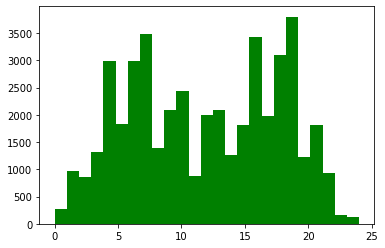

In [10]:
my_new_df.Sentiment_Score
num_bins = 25
   
# n, bins, patches = plt.hist( my_new_df.Sentiment_Score.sort_values(ascending=True).values,num_bins,
#                             density = 1,  
#                             color ='green', 
#                             alpha = 0.7) 
colors = ['green']#, 'blue', 'lime'] 
plt.hist(my_new_df.label, density=False, bins=25,histtype ='bar',color = colors, 
         label = colors)
#plt.hist(my_new_df.Sentiment_Score, density=False, bins=25,histtype ='bar')

In [11]:
my_new_df["label"] = my_new_df["label"].astype("int")

In [13]:
my_new_df.label.min(),my_new_df.label.max()

(0, 24)

In [14]:
len(my_new_df.label.unique())

25

In [15]:
Sentence = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [16]:
fields = [('sentence', Sentence),('label',Label)]

In [17]:
#example = [data.Example.fromlist([df.tweets[i],df.labels[i]], fields) for i in range(df.shape[0])] 


example = [data.Example.fromlist([my_new_df.sentence[i],my_new_df.label[i]], fields) for i in range(my_new_df.shape[0])] 
# Creating dataset
#twitterDataset = data.TabularDataset(path="tweets.csv", format="CSV", fields=fields, skip_header=True)

stanTreeDataset = data.Dataset(example, fields)
(train, valid) = stanTreeDataset.split(split_ratio=[0.85, 0.15], random_state=random.seed(SEED))
Sentence.build_vocab(train)
Label.build_vocab(train)

In [61]:
my_new_df.label.max()

25

In [18]:
(len(train), len(valid))

(38373, 6772)

In [18]:
print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  15467
Size of label vocab :  25
Top 10 words appreared repeatedly : [('the', 30132), ('a', 21887), ('and', 18213), ('of', 18037), ('to', 12704), ('is', 10626), ('s', 10595), ('it', 10241), ('in', 8033), ('that', 7840)]
Labels :  defaultdict(<function _default_unk_index at 0x7fa8567d41e0>, {19: 0, 7: 1, 16: 2, 18: 3, 6: 4, 4: 5, 10: 6, 9: 7, 13: 8, 12: 9, 17: 10, 15: 11, 5: 12, 21: 13, 8: 14, 3: 15, 14: 16, 20: 17, 1: 18, 22: 19, 11: 20, 2: 21, 0: 22, 23: 23, 24: 24})


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)

In [12]:
next(iter(train_iterator))


[torchtext.data.batch.Batch of size 32]
	[.sentence]:('[torch.cuda.LongTensor of size 32x16 (GPU 0)]', '[torch.cuda.LongTensor of size 32 (GPU 0)]')
	[.label]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [21]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Sentence.vocab.stoi, tokens)

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [23]:
# Define hyperparameters
size_of_vocab = len(Sentence.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = len(my_new_df.label.unique())
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)


In [24]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(15467, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=25, bias=True)
)
The model has 4,884,225 trainable parameters


In [25]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [26]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()  
        #print(predictions)
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            #print(predictions)
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 10
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    # train the model
    #train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    train_loss = train(model, train_iterator, optimizer, criterion)


    # evaluate the model
    #valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    

    print(f'\tTrain Loss: {train_loss:.3f} %')
    print(f'\t Val. Loss: {valid_loss:.3f}  \n')
    #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

In [29]:
N_EPOCHS = 100
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    #train_loss = train(model, train_iterator, optimizer, criterion)


    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    #valid_loss = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 2.848 | Train Acc: 44.65%
	 Val. Loss: 2.904 |  Val. Acc: 39.61% 

	Train Loss: 2.827 | Train Acc: 46.99%
	 Val. Loss: 2.889 |  Val. Acc: 41.07% 

	Train Loss: 2.806 | Train Acc: 49.00%
	 Val. Loss: 2.875 |  Val. Acc: 42.77% 

	Train Loss: 2.789 | Train Acc: 50.51%
	 Val. Loss: 2.871 |  Val. Acc: 42.87% 

	Train Loss: 2.777 | Train Acc: 51.52%
	 Val. Loss: 2.852 |  Val. Acc: 44.81% 

	Train Loss: 2.764 | Train Acc: 52.70%
	 Val. Loss: 2.842 |  Val. Acc: 45.60% 

	Train Loss: 2.749 | Train Acc: 54.38%
	 Val. Loss: 2.835 |  Val. Acc: 46.71% 

	Train Loss: 2.734 | Train Acc: 55.84%
	 Val. Loss: 2.818 |  Val. Acc: 48.12% 

	Train Loss: 2.722 | Train Acc: 56.79%
	 Val. Loss: 2.810 |  Val. Acc: 48.67% 

	Train Loss: 2.712 | Train Acc: 57.69%
	 Val. Loss: 2.799 |  Val. Acc: 49.89% 

	Train Loss: 2.698 | Train Acc: 59.20%
	 Val. Loss: 2.786 |  Val. Acc: 51.13% 

	Train Loss: 2.684 | Train Acc: 60.55%
	 Val. Loss: 2.783 |  Val. Acc: 51.67% 

	Train Loss: 2.673 | Train Acc: 61.51%
	

In [ ]:
#load weights and tokenizer

path='./saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

#inference 

import spacy
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    categories = {0: "Negative", 1:"Positive", 2:"Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)

    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]